In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as dsets
from selection import models, data

In [2]:
# Load train set
train = dsets.MNIST('./', train=True, download=True)
imgs = train.data.reshape(-1, 784) / 255.0
labels = train.targets

# Shuffle and split into train and val
inds = torch.randperm(len(train))
imgs = imgs[inds]
labels = labels[inds]
val_x, val_y = imgs[:6000], labels[:6000]
train_x, train_y = imgs[6000:], labels[6000:]

# Load test set
test = dsets.MNIST('./', train=False, download=True)
test_x = test.data.reshape(-1, 784) / 255.0
test_y = test.targets

# Create TabularDatasets (for specifying feature indices)
train_set = data.TabularDataset(train_x, train_y)
val_set = data.TabularDataset(val_x, val_y)
test_set = data.TabularDataset(test_x, test_y)
input_size = train_set.input_size
output_size = train_set.output_size

# Concrete mask

In [3]:
# Create model
model = models.SelectorMLP(
    input_layer='concrete_mask',
    k=20,
    input_size=input_size,
    output_size=output_size,
    hidden=[256, 256],
    activation='elu').cuda(4)

# Train model
model.train(
    train_set,
    val_set,
    lr=1e-3,
    mbsize=256,
    max_nepochs=100,
    start_temperature=10.0,
    end_temperature=0.01,
    loss_fn=nn.CrossEntropyLoss(),
    check_every=10)

--------Epoch = 10--------
Train loss = 0.2010
Val loss = 0.2259
Max = 0.04, Mean = 0.03, Min = 0.03
--------Epoch = 20--------
Train loss = 0.1350
Val loss = 0.1697
Max = 0.11, Mean = 0.06, Min = 0.05
--------Epoch = 30--------
Train loss = 0.2077
Val loss = 0.2286
Max = 0.23, Mean = 0.12, Min = 0.08
--------Epoch = 40--------
Train loss = 0.4136
Val loss = 0.4120
Max = 0.57, Mean = 0.24, Min = 0.14
--------Epoch = 50--------
Train loss = 0.4586
Val loss = 0.4706
Max = 1.00, Mean = 0.58, Min = 0.23
--------Epoch = 60--------
Train loss = 0.3232
Val loss = 0.3529
Max = 1.00, Mean = 0.92, Min = 0.52
--------Epoch = 70--------
Train loss = 0.2783
Val loss = 0.3271
Max = 1.00, Mean = 0.98, Min = 0.70
--------Epoch = 80--------
Train loss = 0.2377
Val loss = 0.3167
Max = 1.00, Mean = 1.00, Min = 0.95
--------Epoch = 90--------
Train loss = 0.2103
Val loss = 0.3109
Max = 1.00, Mean = 1.00, Min = 0.99
--------Epoch = 100--------
Train loss = 0.1879
Val loss = 0.3209
Max = 1.00, Mean = 1.00, 

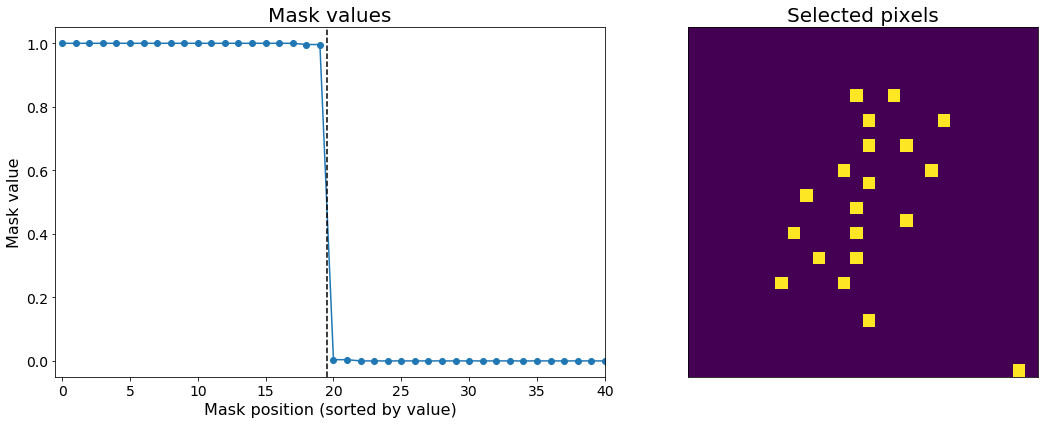

In [4]:
# Verify convergence
m = model.input_layer.sample(n_samples=256)
values = torch.mean(m, dim=0)
sorted_values = torch.sort(values, descending=True).values

# Plot
fig, axarr = plt.subplots(1, 2, figsize=(16, 6))

ax = axarr[0]
ax.plot(np.arange(input_size), sorted_values.cpu().data, marker='o')
ax.axvline(model.input_layer.k - 0.5, color='black', linestyle='--')
ax.set_xlim(-0.5, 2 * model.input_layer.k)
ax.set_title('Mask values', fontsize=20)
ax.set_xlabel('Mask position (sorted by value)', fontsize=16)
ax.set_ylabel('Mask value', fontsize=16)
ax.tick_params('both', labelsize=14)

ax = axarr[1]
ax.imshow(np.reshape(values.cpu().data, (28, 28)))
ax.set_title('Selected pixels', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

In [5]:
# Extract select inds
inds = model.get_inds()

# Restrict data to selected indices
train_set.set_inds(inds)
val_set.set_inds(inds)
test_set.set_inds(inds)

# Train debiased model
model = models.MLP(
    input_size=len(inds),
    output_size=output_size,
    hidden=[256, 256],
    activation='elu').cuda(4)

model.train(
    train_set,
    val_set,
    lr=1e-3,
    mbsize=256,
    max_nepochs=100,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=False)

# Calculate loss on test set
print('Accuracy = {:.3f}'.format(
    model.evaluate(test_set, models.utils.Accuracy()).item()))

# Reset data
train_set.set_inds()
val_set.set_inds()
test_set.set_inds()

Accuracy = 0.907


# Concrete selector

In [6]:
# Create model
model = models.SelectorMLP(
    input_layer='concrete_selector',
    k=20,
    input_size=input_size,
    output_size=output_size,
    hidden=[256, 256],
    activation='elu').cuda(4)

# Train model
model.train(
    train_set,
    val_set,
    lr=1e-3,
    mbsize=256,
    max_nepochs=100,
    start_temperature=10.0,
    end_temperature=0.01,
    loss_fn=nn.CrossEntropyLoss(),
    check_every=10)

--------Epoch = 10--------
Train loss = 0.5956
Val loss = 0.6060
Max = 0.05, Mean = 0.02, Min = 0.01
--------Epoch = 20--------
Train loss = 0.3870
Val loss = 0.4033
Max = 0.38, Mean = 0.10, Min = 0.03
--------Epoch = 30--------
Train loss = 0.3404
Val loss = 0.3570
Max = 0.53, Mean = 0.26, Min = 0.11
--------Epoch = 40--------
Train loss = 0.3346
Val loss = 0.3579
Max = 0.95, Mean = 0.57, Min = 0.23
--------Epoch = 50--------
Train loss = 0.2960
Val loss = 0.3348
Max = 1.00, Mean = 0.85, Min = 0.43
--------Epoch = 60--------
Train loss = 0.2510
Val loss = 0.3131
Max = 1.00, Mean = 0.98, Min = 0.81
--------Epoch = 70--------
Train loss = 0.2227
Val loss = 0.3047
Max = 1.00, Mean = 0.99, Min = 0.95
--------Epoch = 80--------
Train loss = 0.2049
Val loss = 0.3120
Max = 1.00, Mean = 1.00, Min = 0.99
--------Epoch = 90--------
Train loss = 0.1892
Val loss = 0.3132
Max = 1.00, Mean = 1.00, Min = 1.00
--------Epoch = 100--------
Train loss = 0.1809
Val loss = 0.3287
Max = 1.00, Mean = 1.00, 

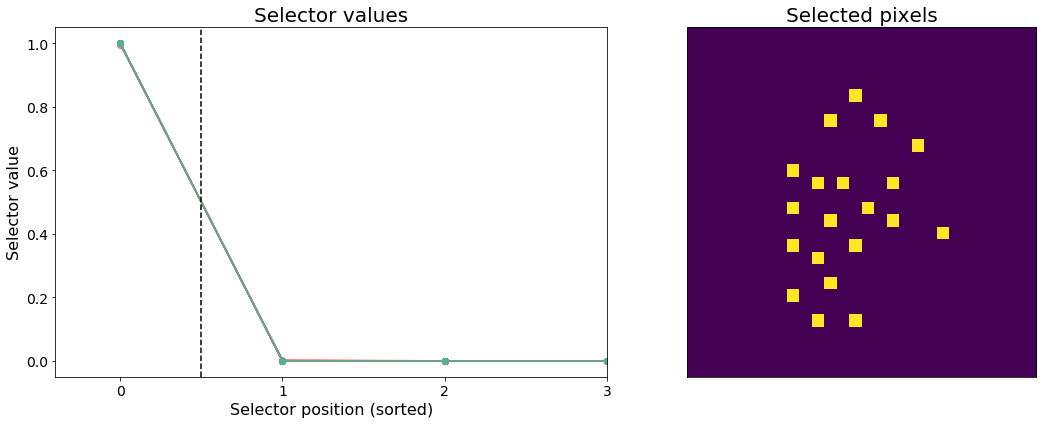

In [7]:
# Verify convergence
M = model.input_layer.sample(n_samples=256)
values = torch.mean(M, dim=0)
sorted_values = torch.sort(values, dim=1, descending=True).values

# Plot
fig, axarr = plt.subplots(1, 2, figsize=(16, 6))

ax = axarr[0]
for i in range(model.input_layer.k):
    ax.plot(np.arange(input_size), sorted_values[i].cpu().data,
            marker='o', alpha=0.5)
ax.set_xlim(-0.4, 3)
ax.set_xticks(np.arange(4))
ax.axvline(0.5, color='black', linestyle='--')
ax.set_title('Selector values', fontsize=20)
ax.set_xlabel('Selector position (sorted)', fontsize=16)
ax.set_ylabel('Selector value', fontsize=16)
ax.tick_params('both', labelsize=14)

ax = axarr[1]
ax.imshow(np.reshape(torch.sum(values, dim=0).cpu().data,
                     (28, 28)))
ax.set_title('Selected pixels', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

In [8]:
# Extract select inds
inds = model.get_inds()

# Restrict data to selected indices
train_set.set_inds(inds)
val_set.set_inds(inds)
test_set.set_inds(inds)

# Train debiased model
model = models.MLP(
    input_size=len(inds),
    output_size=output_size,
    hidden=[256, 256],
    activation='elu').cuda(4)

model.train(
    train_set,
    val_set,
    lr=1e-3,
    mbsize=256,
    max_nepochs=100,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=False)

# Calculate loss on test set
print('Accuracy = {:.3f}'.format(
    model.evaluate(test_set, models.utils.Accuracy()).item()))

# Reset data
train_set.set_inds()
val_set.set_inds()
test_set.set_inds()

Accuracy = 0.898


# Concrete gates

In [9]:
# Create model
model = models.SelectorMLP(
    input_layer='concrete_gates',
    input_size=input_size,
    output_size=output_size,
    hidden=[256, 256],
    activation='elu').cuda(4)

# Train model
model.train(
    train_set,
    val_set,
    lam=0.005,
    lr=1e-3,
    mbsize=256,
    max_nepochs=1000,
    start_temperature=1.0,
    end_temperature=0.0001,
    loss_fn=nn.CrossEntropyLoss(),
    check_every=100)

--------Epoch = 100--------
Train loss = 0.3439
Val loss = 0.3813
Mean dist = 0.05, Max dist = 0.48, Num sel = 7
--------Epoch = 200--------
Train loss = 0.2921
Val loss = 0.3671
Mean dist = 0.03, Max dist = 0.50, Num sel = 22
--------Epoch = 300--------
Train loss = 0.2119
Val loss = 0.3811
Mean dist = 0.01, Max dist = 0.50, Num sel = 31
--------Epoch = 400--------
Train loss = 0.1716
Val loss = 0.4611
Mean dist = 0.01, Max dist = 0.42, Num sel = 29
--------Epoch = 500--------
Train loss = 0.1514
Val loss = 0.5507
Mean dist = 0.00, Max dist = 0.45, Num sel = 27
--------Epoch = 600--------
Train loss = 0.1438
Val loss = 0.6365
Mean dist = 0.00, Max dist = 0.42, Num sel = 27
--------Epoch = 700--------
Train loss = 0.1392
Val loss = 0.6927
Mean dist = 0.00, Max dist = 0.31, Num sel = 26
--------Epoch = 800--------
Train loss = 0.1437
Val loss = 0.7269
Mean dist = 0.00, Max dist = 0.11, Num sel = 26
--------Epoch = 900--------
Train loss = 0.1383
Val loss = 0.7236
Mean dist = 0.00, Max d

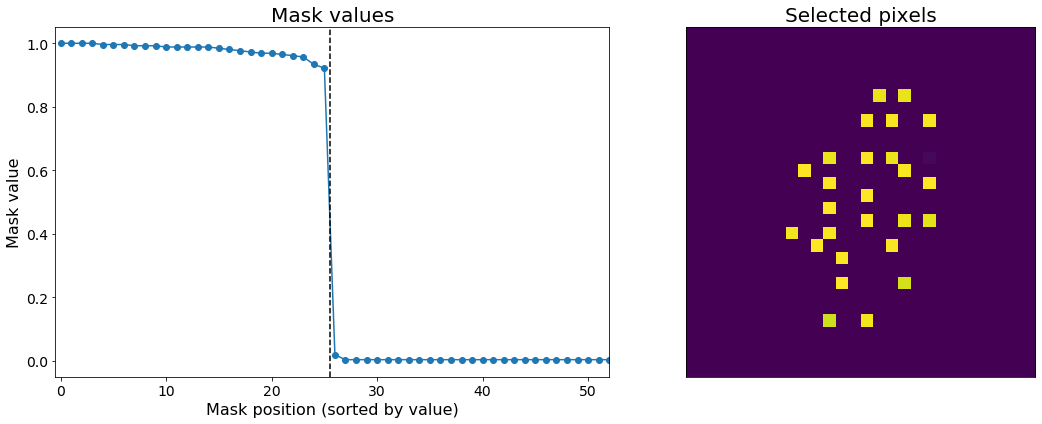

In [10]:
# Verify convergence
m = model.input_layer.sample(n_samples=256)
values = torch.mean(m, dim=0)
sorted_values = torch.sort(values, descending=True).values

# Plot
fig, axarr = plt.subplots(1, 2, figsize=(16, 6))

ax = axarr[0]
ax.plot(np.arange(input_size), sorted_values.cpu().data,
        marker='o')
ind = (sorted_values < 0.5).nonzero()[0].item()
ax.axvline(ind - 0.5, color='black', linestyle='--')
ax.set_xlim(-0.5, min(input_size, 2 * ind))
ax.set_title('Mask values', fontsize=20)
ax.set_xlabel('Mask position (sorted by value)', fontsize=16)
ax.set_ylabel('Mask value', fontsize=16)
ax.tick_params('both', labelsize=14)

ax = axarr[1]
ax.imshow(np.reshape(values.cpu().data, (28, 28)))
ax.set_title('Selected pixels', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

In [11]:
# Extract selected inds
inds = model.get_inds(threshold=0.5)

# Restrict data to selected indices
train_set.set_inds(inds)
val_set.set_inds(inds)
test_set.set_inds(inds)

# Train debiased model
model = models.MLP(
    input_size=len(inds),
    output_size=output_size,
    hidden=[256, 256],
    activation='elu').cuda(4)

model.train(
    train_set,
    val_set,
    lr=1e-3,
    mbsize=256,
    max_nepochs=100,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=False)

# Calculate loss on test set
print('Accuracy = {:.3f}'.format(
    model.evaluate(test_set, models.utils.Accuracy()).item()))

# Reset data
train_set.set_inds()
val_set.set_inds()
test_set.set_inds()

Accuracy = 0.939
